DSCI 100 Project Proposal: 
- Group 44, section 007
- Lucas Alexander, Eric Lee, James He, Sadaf Ayisha Hamidi

***The Nowcast: Who cares if it will rain? Indirectly determining if it is raining with atmospheric measurements***

***INTRODUCTION***
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

     METAR (Meteorological Aerodrome Reports) is the most common and widely accepted format for outputting data from weather measurements. Uploaded essentially constantly, there is a huge outflow of data on atmospheric conditions for nearly every moment, in nearly every inhabited place. They measure such variables as cloud cover, wind speed, and precipitation, amongst others. While predicting a weather forecast is a notoriously difficult task, it is much easier to make a "nowcast", where one makes guesses about current weather conditions within that time period. In this project, we intend to use the METAR data from a weather station just outside Des Moines from May 22 - June 15, 2008, to make a model that can determine whether or not there is precipitation happening at a given time.
     
     research question: Can current precipitation in Des Moines, Iowa be predicted based on (predictor variables)?
     
     We chose this period of time as a major flood occurred at this time in Iowa (Central Iowa Floods of 2008, National Weather Service), which will give us a more even distribution of our two categorical variables (raining and not raining), hopefully improving the accuracy of our K-nearest neighbor model. The station takes measurements every 20 minutes, and the data are collected and uploaded by Iowa State University.

***METHODS AND RESULTS***

First we loaded the approrpriate libraries to perform our classification analysis, tidyverse and tidymodels, also setting the seed to ensure our code is reproducible. Due to some issues with reproducibility during the coding process, we included our seed at the top of every cell to be cautious.

In [1]:
#loading appropriate libraries and setting seed
library(tidyverse)
library(tidymodels)
set.seed(420)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We then loaded our csv data file using its URL which was extracted from the Iowa Automated Surface Observation Service (ASOS) website (CITE).

In [2]:
#loading data into R
metar_data <- read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=IKV&data=all&year1=2008&month1=5&day1=22&year2=2008&month2=6&day2=15&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=empty&trace=T&direct=no&report_type=3&report_type=4")

Rows: 4114 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): station, skyc1, skyc2, skyc3, wxcodes, metar
dbl  (13): tmpf, dwpf, relh, drct, sknt, p01i, alti, vsby, gust, skyl1, skyl...
lgl  (10): mslp, skyc4, skyl4, ice_accretion_1hr, ice_accretion_3hr, ice_acc...
dttm  (1): valid

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


After loading our data, we formatted our categorical variable `precip` from a numerical data type with the value of precipitation in inches into a factor data type with any value over 0 being represented as 1. This allows us to predict the `precip` column using the K-nearest neighbors algorithm. We then selected all numerical variables with a minimum number of NA values to use as our candidate predictor variables.

In [3]:
#wrangling data to elimate non-predictor variables
#formatted predicted class column "precip" so it can be used by KNN algorithm
set.seed(420)

metar_data['p01i'][metar_data['p01i'] > 0 ] <- 1

metar_wrangled <- metar_data |>  
    mutate(precip = as_factor(p01i)) |>
    select(tmpf, dwpf, relh, drct, sknt, alti, vsby, feel, precip)|>
        filter(!is.na(precip), !is.na(tmpf), !is.na(dwpf), !is.na(relh), 
               !is.na(drct), !is.na(sknt), !is.na(alti), !is.na(vsby), !is.na(feel))

head(metar_wrangled)

tmpf,dwpf,relh,drct,sknt,alti,vsby,feel,precip
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
59.0,46.4,62.92,120,7,29.87,10,59.0,0
59.0,49.0,69.38,100,8,29.86,10,59.0,1
58.0,48.0,69.27,100,10,29.84,10,58.0,1
57.2,46.4,67.12,100,11,29.84,10,57.2,1
58.0,49.0,71.91,90,14,29.80,10,58.0,1
59.0,49.0,69.38,140,8,29.84,10,59.0,1


After wrangling our data, we split our original data frame so that 75% of observations were included in the training set, and 25% in the testing set.

In [4]:
set.seed(420)
#splitting data into test and training sets
metar_split <- initial_split(metar_wrangled, prop = 0.75, strata = precip)
metar_training_pre <- training(metar_split)
metar_testing_pre <- testing(metar_split)

Using our training data, we performed forward selection to determine which combination of our candidate predictor variables give us the best model accuracy. 

In [5]:
set.seed(420)
#generate names object containing candidate predictor variables
names <- colnames(metar_training_pre |> select(-precip))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
predictor_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
metar_vfold1 <- vfold_cv(metar_training_pre, v = 5, strata = precip)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("precip", "~", paste(names, collapse="+"))

        # create a recipe from the model string
        metar_recipe1 <- recipe(as.formula(model_string), 
                                data = metar_training_pre) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(metar_recipe1) |>
          add_model(predictor_spec) |>
          tune_grid(resamples = metar_vfold1, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,precip ~ tmpf+dwpf+relh+drct+sknt+alti+vsby+feel,0.9341571
2,precip ~ dwpf+relh+drct+sknt+alti+vsby+feel,0.9341534
3,precip ~ relh+drct+sknt+alti+vsby+feel,0.9246182
4,precip ~ drct+sknt+alti+vsby+feel,0.9012489
5,precip ~ sknt+alti+vsby+feel,0.8795211
6,precip ~ alti+vsby+feel,0.8769462
7,precip ~ alti+feel,0.8691127
8,precip ~ alti,0.7868307


**Table 1: Results of Forward Selection**
- the classifer accuracy of our model using cross validation on training data for each combination of predictor variables.

From the forward selection procedure, we determined the combination of predictor variables dwpf, relh, drct, sknt, alti, vsby, and feel will give the best trade off of accuracy and simplicicty for our model. Since there is only a marginal change in accuracy when adding the tmpf predictor variable, it is likely an irrelevant variable and was not included.

**Our best combination of predictor variables**

- `dwpf` = Dew-point Temperature (°F)
- `relh` = Relative Humidity Percentage (%)
- `drct` = Wind Direction in Degrees from True North (degrees)
- `sknt` = Wind Speed (knots)
- `alti` = Pressure Altimeter (inches)
- `vsby` = Visibility (miles)
- `feel` = Apparent Temperature (°F)

**Our categorical variable**
- `precip` = Precipitation for 1-hour (0 = no precipitation, 1 = precipitation occuring) 

After selecting our predictor variables, we generated new testing and training data frames with our best combination of predictors using `select()` on the training and test sets to remove the tmpf variable.

In [6]:
set.seed(420)
#generating new data frames with optimal combination of predictor variables
metar_training <- metar_training_pre |>
    select(-tmpf)

metar_testing <- metar_testing_pre |>
    select(-tmpf)

head(metar_training)
head(metar_testing)

dwpf,relh,drct,sknt,alti,vsby,feel,precip
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
46.4,62.92,120,7,29.87,10,59.0,0
48.2,63.15,140,9,29.84,10,60.8,0
46.4,59.01,130,12,29.84,10,60.8,0
50.0,93.55,120,12,29.97,10,51.8,0
51.8,100.00,110,16,29.99,10,51.8,0
51.8,100.00,100,15,30.00,10,51.8,0


dwpf,relh,drct,sknt,alti,vsby,feel,precip
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
46.4,67.12,100,11,29.84,10,57.2,1
49.0,69.38,140,8,29.84,10,59.0,1
50.0,63.38,140,13,29.85,10,62.6,0
51.0,96.37,120,9,29.98,10,52.0,1
51.0,96.37,110,8,30.00,10,52.0,1
50.0,93.55,120,18,29.94,10,51.8,0


We then generated an object with the number of rows in the training set, grouped by our categorical variable `precip` , and used `summarize()` to determine the relative quantities of each of our classes.

In [7]:
#summary table with percent distribution of precip classes: exploratory analysis
train_rows <- nrow(metar_training)
metar_classes <- metar_training |>
    group_by(precip) |>
    summarize(
        count = n(),
        percentage = n()/train_rows*100)

metar_classes  

precip,count,percentage
<fct>,<int>,<dbl>
0,896,77.64298
1,258,22.35702


**Table 2: Distribution of Classes Within Training Set**
- In our training set, ~78 % of observations were taken at a time point where it was not
    currently raining, and ~22 % of observations were taken at a time point when it was raining

We then performed an exploratory visualization to see if there was a clear relationship between relative humidity and precipitation.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



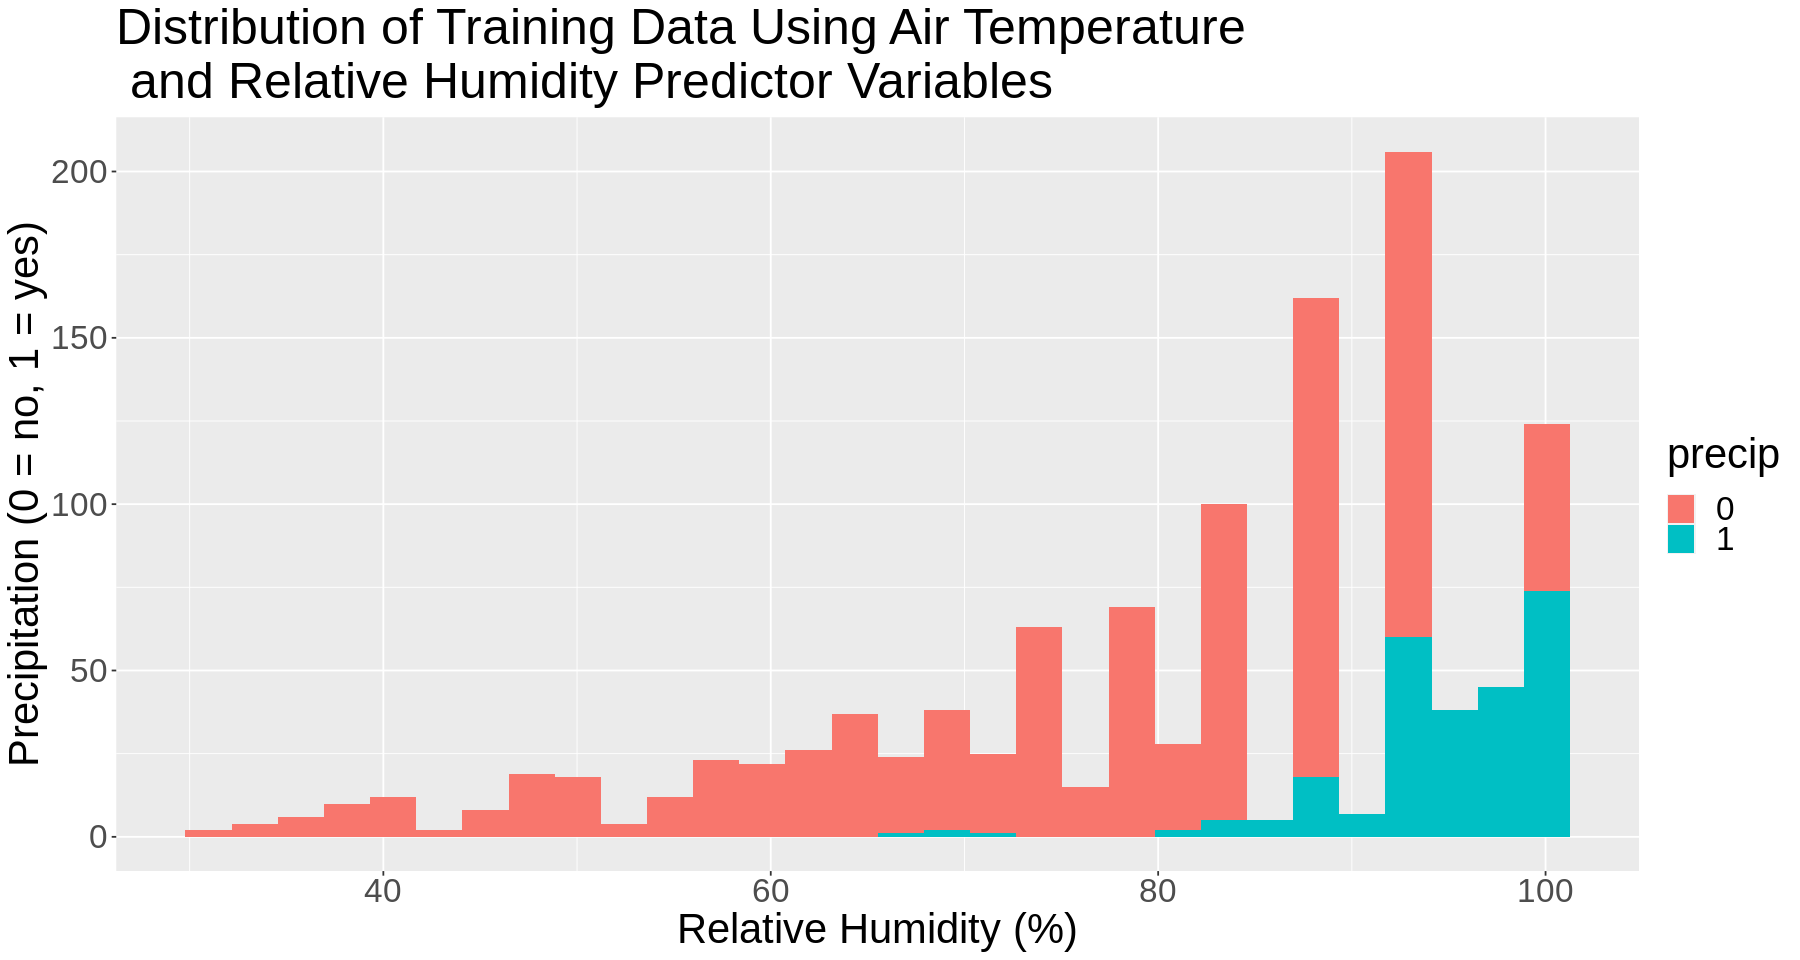

In [16]:
set.seed(420)
#exploratory data visualizations
options(repr.plot.height = 8, repr.plot.width = 15)

# WRITE A CAPTION ON WHY RELATIVE HUMIDITY IS A GOOD VARIABLE

metar_vis2 <- metar_training |>
    ggplot(aes(x = relh)) +
    geom_histogram(aes(fill = precip)) +
    theme(text = element_text(size = 25)) +
    labs(y = "Precipitation (0 = no, 1 = yes)", x = "Relative Humidity (%)", color = "Precipitation") +
    scale_color_hue(labels = c("no", "yes")) +
    ggtitle("Distribution of Training Data Using Air Temperature\n and Relative Humidity Predictor Variables")
metar_vis2

**Figure 1: Relationship between Relative Humidity and precipitation**
- Exploratory data analysis using `relh` predictor variable to investigate its relationship with the categorical variable `precip`. There seems to be a positive relationship between increased humidity percentage (~80 % and higher) and precipitation. 

*JAMES START WRITING FROM HERE*

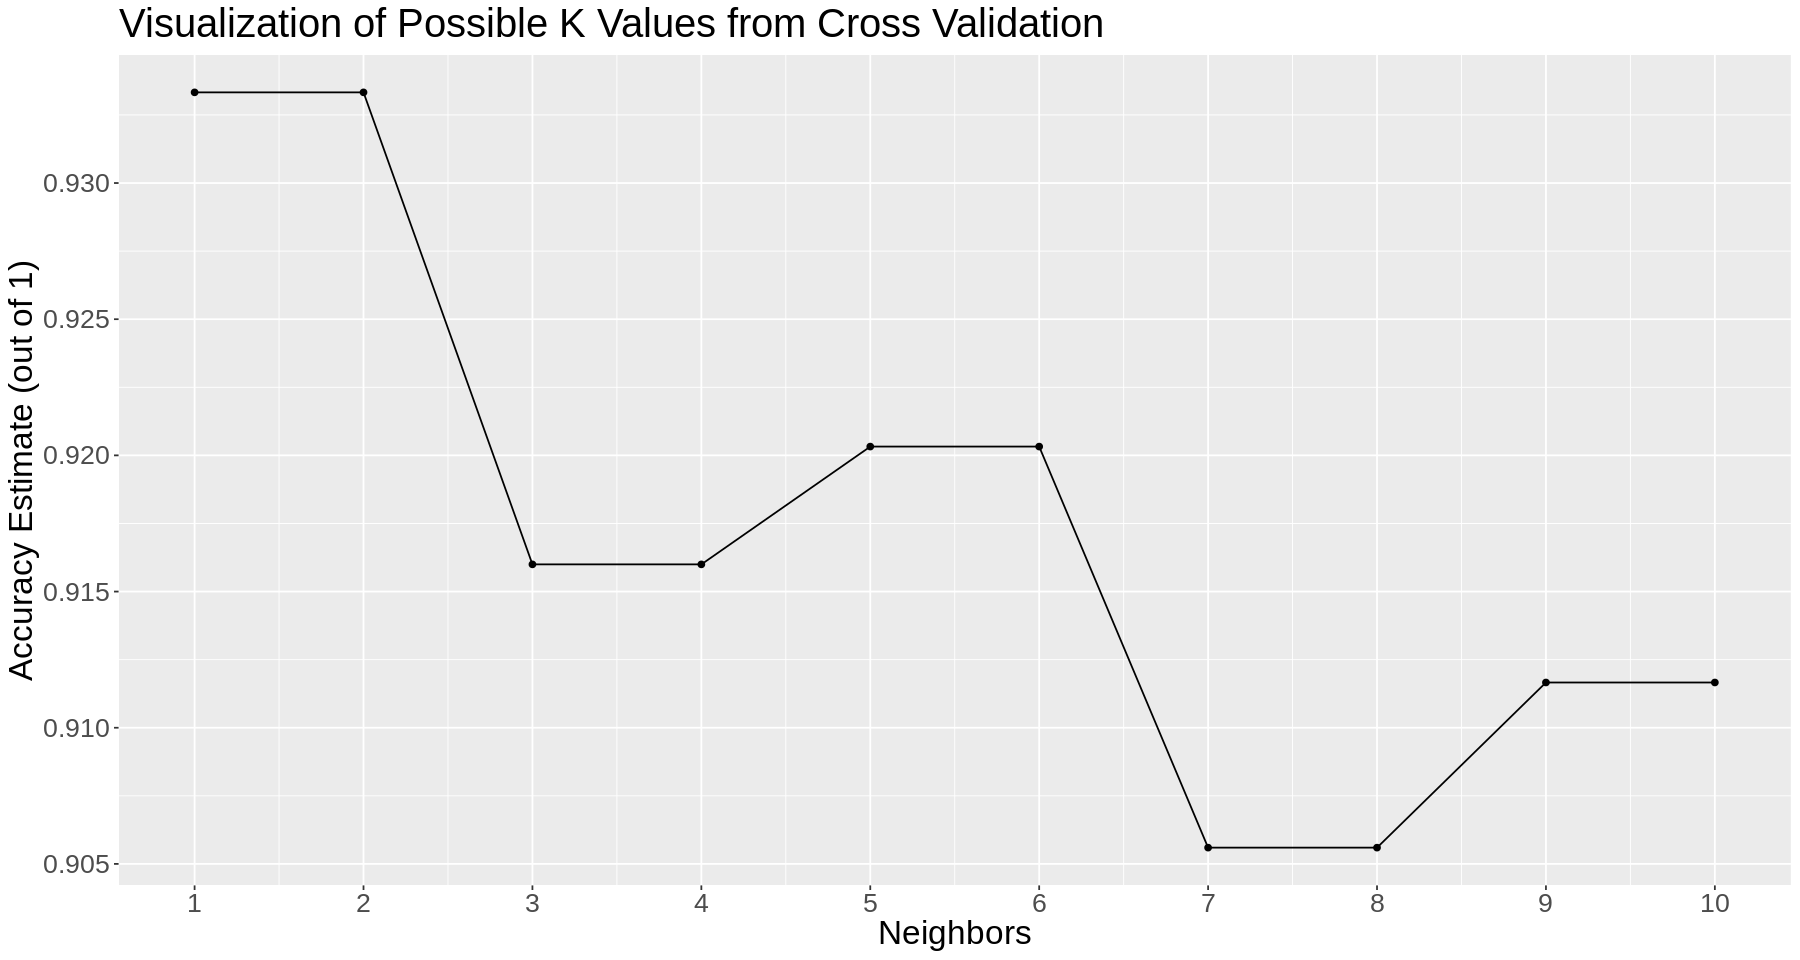

In [9]:
set.seed(420)
#generating recipe
metar_recipe <- recipe(precip ~ dwpf + relh + drct + alti + vsby + feel + sknt, data = metar_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#generating KNN model for cross validation
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#generating cross validation fold object
metar_vfold <- vfold_cv(metar_training, v = 5, strata = precip)

#generating grid of K values
k_vals <- tibble(neighbors = seq(1:10))

#creating workflow and computing cross validation accuracies
metar_results <- workflow() |>
    add_recipe(metar_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = metar_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

#plotting K values against accuracy to determine K
cross_val_plot <- metar_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate (out of 1)") +
    ggtitle("Visualization of Possible K Values from Cross Validation") +
    scale_x_continuous(breaks=1:10)+
    theme(text = element_text(size = 20))

cross_val_plot

From the plot above we determined the best choice was k = 2, since the accuracy is highest at this value by a substantial amount.

In [10]:
set.seed(420)
#generating KNN model with best k value
metar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode("classification")

#generating final workflow
metar_fit <- workflow() |>
    add_recipe(metar_recipe) |>
    add_model(metar_spec) |>
    fit(data = metar_training)

#generating predictions on testing data
metar_predictions <- predict(metar_fit, metar_testing) |>
    bind_cols(metar_testing)

#computing prediction accuracies
metar_accuracy <- metar_predictions |>
    metrics(truth = precip, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)

#comparing predictions to true values in a confusion matrix
metar_cm <- metar_predictions |>
    conf_mat(truth = precip, estimate =.pred_class)

In [11]:
metar_accuracy

.metric,.estimate
<chr>,<dbl>
accuracy,0.9168831


**Table 3: Tuned Model Accuracy**
- After tuning our model, it had an accuracy of ~ 92% when used to predict the labels for our testing data set.

In [12]:
metar_cm

          Truth
Prediction   0   1
         0 282  15
         1  17  71

**Table 4: Confusion Matrix for Predictions**
- The model correctly predicted a larger fraction of observations where it was not raining (282 correct, 17 incorrect) when compared to observations where it was raining (71 correct, 15 incorrect).

.pred_class,dwpf,relh,drct,sknt,alti,vsby,feel,precip
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,46.4,67.12,100,11,29.84,10,57.2,1
1,49.0,69.38,140,8,29.84,10,59.0,1
1,50.0,63.38,140,13,29.85,10,62.6,0
1,51.0,96.37,120,9,29.98,10,52.0,1
0,51.0,96.37,110,8,30.00,10,52.0,1
1,50.0,93.55,120,18,29.94,10,51.8,0


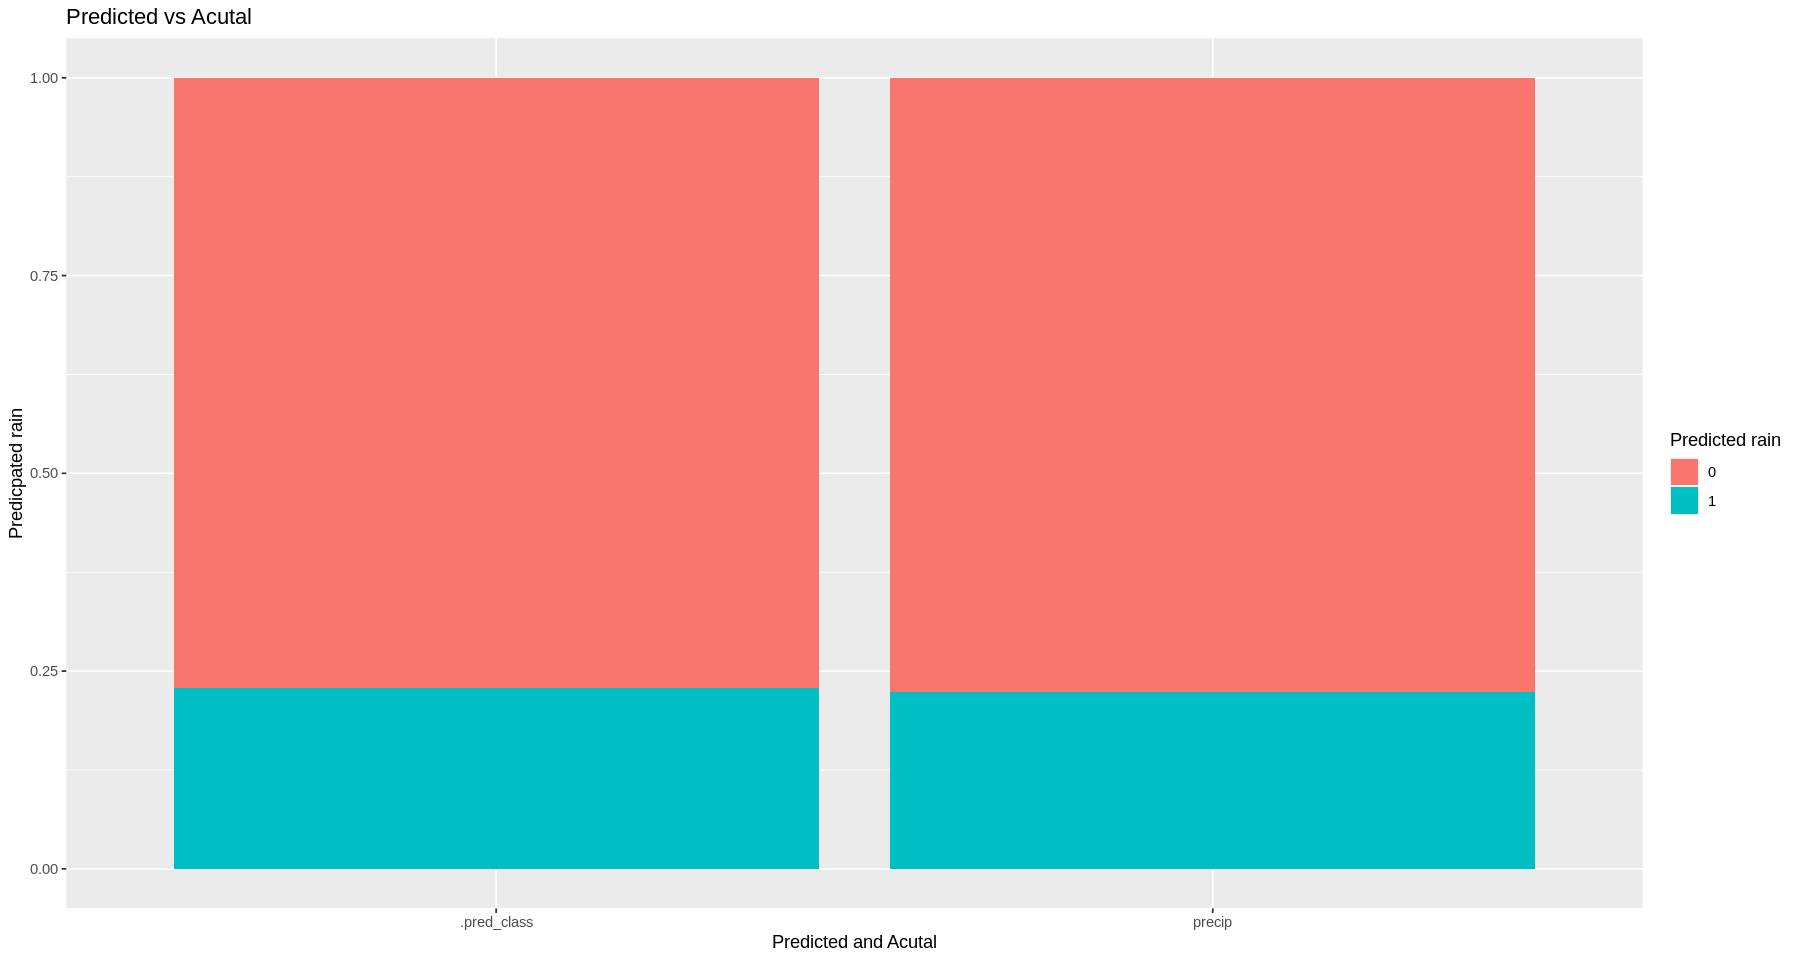

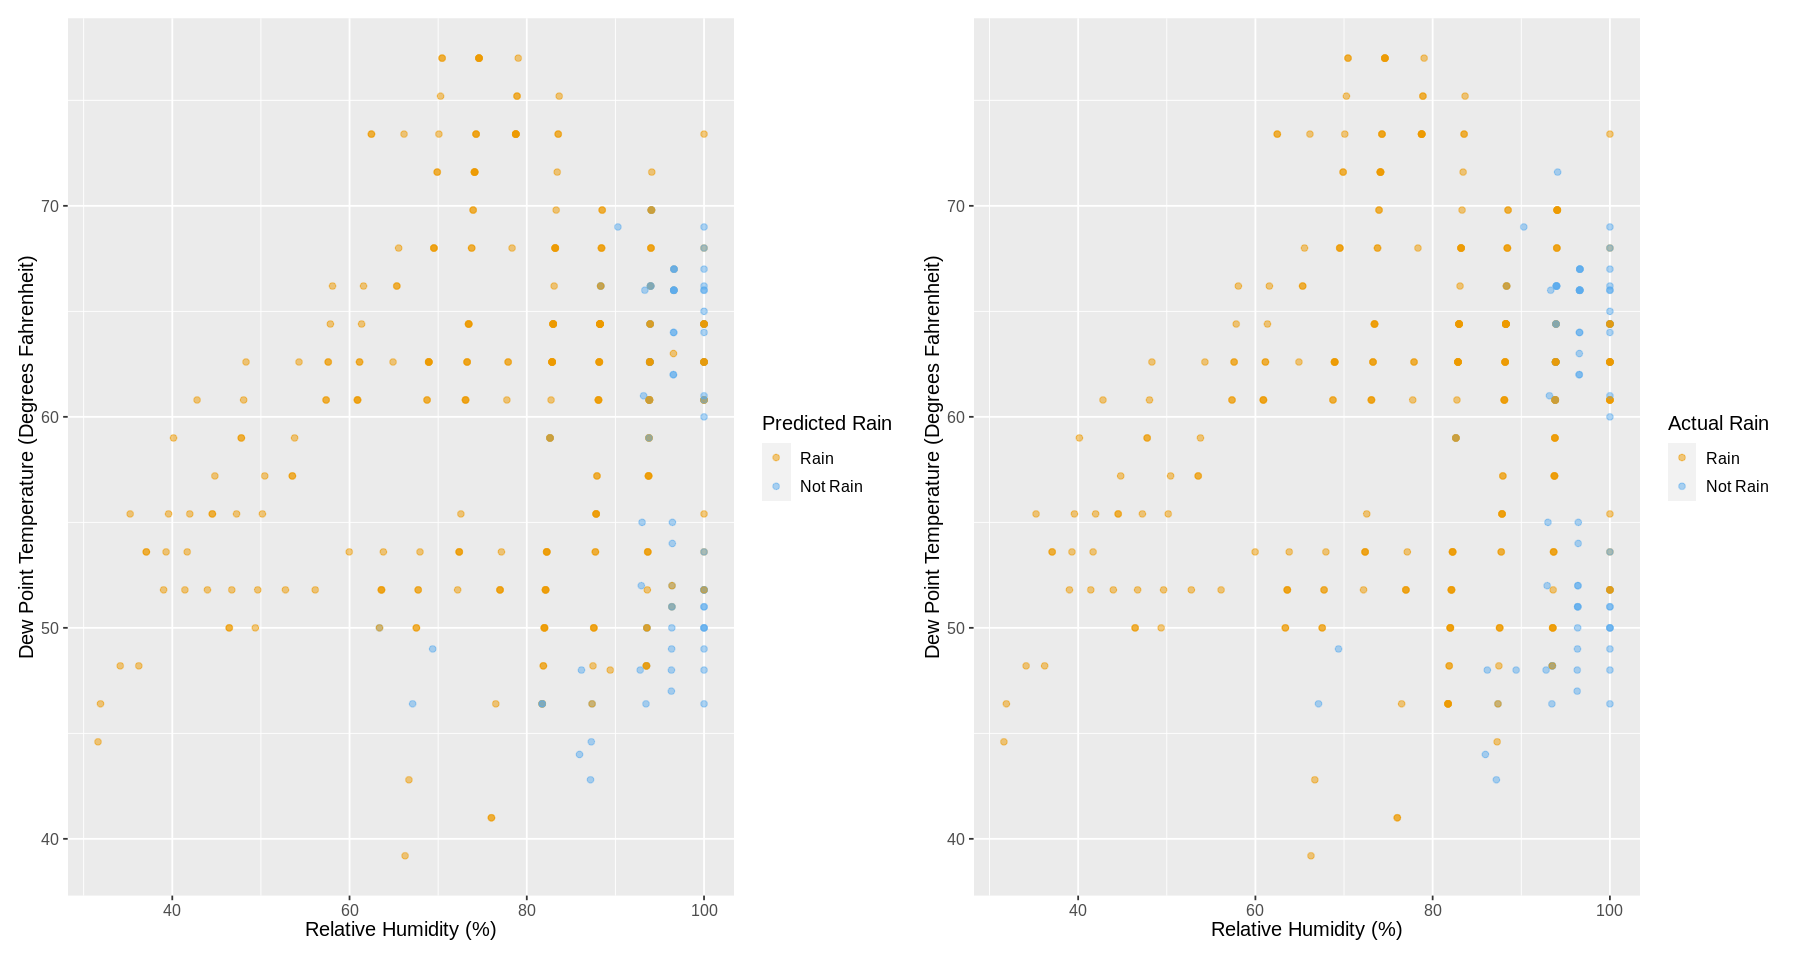

In [13]:
#visualization of results
library(ggplot2)
library(patchwork)

metar_predictions_1 <- metar_predictions |>
select(precip, .pred_class) |>
pivot_longer(cols = precip:.pred_class, 
             names_to = "values")

# A <- c("Actual")

# actual_result <- metar_predictions_1 |>
# group_by(precip) |>
# summarize(n = n()) |>
# pivot_wider(names_from = precip,
#             values_from = n) |>
# cbind(A)

# A <- c("Predicted")

# predicted_result <- metar_predictions_1 |>
# group_by(.pred_class) |>
# summarize(n = n()) |>
# pivot_wider(names_from = .pred_class,
#             values_from = n) |>
# cbind(A)

# merged <- rbind(predicted_result, actual_result)

# merged



# predictions_plot <- merged |> 
# ggplot(aes(x = A, fill = 0 )) + 
#    geom_bar(position = 'fill') + 
#    xlab("Whether made an prediciton") +
#    ylab("Predicpated") +
#    labs(fill = "Did make a prediction") +
#    ggtitle("Predicted vs Acutal")

predictions_bar_plot <- metar_predictions_1 |> 
ggplot(aes(x = values, fill = value )) + 
   geom_bar(position = 'fill') + 
   xlab("Predicted and Acutal") +
   ylab("Predicpated rain") +
   labs(fill = "Predicted rain") +
   ggtitle("Predicted vs Acutal")

predictions_bar_plot
head(metar_predictions)

predictions_scatter_plot_1 <- metar_predictions |>
  ggplot(aes(x = relh, y = dwpf, color = .pred_class)) +
  geom_point(alpha = 0.5) +
  labs(y = "Dew Point Temperature (Degrees Fahrenheit)", x = "Relative Humidity (%)", color = "Predicted Rain") +
  scale_color_manual(labels = c("Rain", "Not Rain"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))

predictions_scatter_plot_2 <- metar_predictions |>
  ggplot(aes(x = relh, y = dwpf, color = precip)) +
  geom_point(alpha = 0.5) +
  labs(y = "Dew Point Temperature (Degrees Fahrenheit)", x = "Relative Humidity (%)", color = "Actual Rain") +
  scale_color_manual(labels = c("Rain", "Not Rain"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))

scatter_plot <- predictions_scatter_plot_1 + predictions_scatter_plot_2

scatter_plot



***Discussion***
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

**from the proposal** 

    We expect to able to predict whether or not there is precipitation in Des Moines, Iowa at any given time between May 22 and June 15 2008. These findings are important as they not only allow us to determine if there is precipitation in Des Moines within the selected time frame, but could also help in discovering the "nowcast" of any point in time at any station from the data set within the date range provided using slight modifications to our original classification. The classification coded for could lead to future questions such as: Could a similar method be used to predict future forecasts this way? Could a classification be coded for in the future to distinguish the type of precipitation at that time point using the same dataset? There are numerous possibilities for future analysis by using this classification as a basis. 
    
**Answer** 

With our model, we were successfully able to predict whether or not there was precipitation in Des Moines, Iowa at any given time between May 22 and June 15 2008 with 94% accuracy. This is what we expected to find since many predictors that contribute to forming precipitation or are a result of precipitation being formed were considered and applied to the designed model. These findings are important as they not only allow us to determine if there was precipitation in Des Moines within the selected time frame, but could also help in discovering the "nowcast" of any point in time at any station from the data set within the date range provided using slight modifications to our original classification. The classification coded for could lead to future questions such as: Could a similar method be used to predict future forecasts this way? Could a classification be coded for in the future to distinguish the type of precipitation at that time point using the same dataset? There are numerous possibilities for future analysis by using this classification as a basis. 

***References***
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.
    - actual data file: https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=IKV&data=all&year1=2008&month1=5&day1=22&year2=2008&month2=6&day2=15&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=empty&trace=T&direct=no&report_type=3&report_type=4
    - website we got it from:https://mesonet.agron.iastate.edu/request/download.phtml

**General notes/questions:**
- 2000 word written limit NOT INCLUDING CITATIONS